In [1]:
import qiskit as qc
from qiskit import QuantumCircuit
import numpy as np
from numpy import random

/home/jupyter-arturolopez/.local/lib/python3.9/site-packages/qiskit/providers/aer/pulse/qutip_extra_lite/fastsparse.py:57: DeprecationWarning: Please use `upcast` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import (upcast, isdense, isscalarlike, get_index_dtype)
/home/jupyter-arturolopez/.local/lib/python3.9/site-packages/qiskit/providers/aer/pulse/qutip_extra_lite/fastsparse.py:57: DeprecationWarning: Please use `isdense` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import (upcast, isdense, isscalarlike, get_index_dtype)
/home/jupyter-arturolopez/.local/lib/python3.9/site-packages/qiskit/providers/aer/pulse/qutip_extra_lite/fastsparse.py:57: DeprecationWarning: Please use `isscalarlike` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import (upcast, isdense, isscalarlike, get_inde

In [2]:
def randomBC(numCycles,numQubits): #input function (with appropriate limitations), requires at least 2 qubits
    randBC = QuantumCircuit(numQubits)
    poss_EZgates = ["X","Y","Z","H","I"]
    for i in range(numCycles-1):
        for j in range(numQubits):
            a = np.random.choice(poss_EZgates)
            if a == "X":
                randBC.x(j)
            elif a == "Y":
                randBC.y(j)
            elif a == "Z":
                randBC.z(j)
            elif a == "H":
                randBC.h(j)
            else:
                randBC.id(j)
        b = np.random.randint(0,numQubits)
        c = np.random.randint(0,numQubits)
        while c == b:
            c = np.random.randint(0,numQubits)
        randBC.cx(b,c)
        randBC.barrier()
    for j in range(numQubits):
        a = np.random.choice(poss_EZgates)
        if a == "X":
            randBC.x(j)
        elif a == "Y":
            randBC.y(j)
        elif a == "Z":
            randBC.z(j)
        elif a == "H":
            randBC.h(j)
        else:
            randBC.id(j)
    return randBC

In [3]:
numC = np.random.randint(4,8)
numQ = np.random.randint(2,5)
randBC = randomBC(numC,numQ)
randBC.draw()

┌───┐      ░ ┌───┐      ░ ┌───┐      ░ ┌───┐
q_0: ┤ H ├──────░─┤ Y ├──■───░─┤ X ├──────░─┤ X ├
     ├───┤┌───┐ ░ ├───┤┌─┴─┐ ░ ├───┤┌───┐ ░ ├───┤
q_1: ┤ X ├┤ X ├─░─┤ Z ├┤ X ├─░─┤ Y ├┤ X ├─░─┤ Z ├
     ├───┤└─┬─┘ ░ ├───┤└───┘ ░ ├───┤└─┬─┘ ░ ├───┤
q_2: ┤ I ├──┼───░─┤ Y ├──────░─┤ Z ├──┼───░─┤ Y ├
     ├───┤  │   ░ ├───┤      ░ ├───┤  │   ░ ├───┤
q_3: ┤ X ├──■───░─┤ Z ├──────░─┤ H ├──■───░─┤ Z ├
     └───┘      ░ └───┘      ░ └───┘      ░ └───┘

In [4]:
def parsing(QuantumCircuit):
    qasm = QuantumCircuit.qasm()
    lis = []
    lin = ""
    for s in qasm:
        if s == ";":
            lis.append(lin)
            lin=""
        elif s == "\n":
            pass
        else:
            lin += s
    
    lis.pop(0)
    lis.pop(0)
    #getting rid of the first two lines of the qasm code
    #could also make a while loop to pop() the lines that don't start with qreg
    
    if "qreg" in lis[0]:
        qreg=lis[0]
        numQubits=int(qreg[-2])
        lis.pop(0)
    else:
        print("There is an error in getting the number of qubits")
    
    if "creg" in lis[0]: #a restriction we do not have is the number of 
        lis.pop(0) # classical bits in the inputted bare circuit
    
    easyGates = []
    numCycles = 1
    for i in range(len(lis)):
        line = lis[i]
        if "h" in line:
            easyGates.append("H")
        elif "x" in line and "c" not in line:
            easyGates.append("X")
        elif "y" in line:
            easyGates.append("Y")
        elif "z" in line:
            easyGates.append("Z")
        #elif "t" in line:
            #easyGates.append("T") not taking T as a possibility in our bare circuit gates anymore
        elif "id" in line:
            easyGates.append("I")
        elif "barrier" in line:
            numCycles += 1
        elif "cx" in line:
            continue
        else:
            print(f"unexpected line or gate in qasm interpretation in line {i} ")
    
    controls = []
    targets = []
    
    for i in range(len(lis)):
        line = lis[i]
        if "cx" in line:
            for j in range(len(line)):
                if line[j] == "]":
                    a=line[j-1]
                    if j == 6:
                        controls.append(a)
                    elif j==11:
                        targets.append(a)
                    else:
                        print("something weird happening with cx")
    return numQubits, numCycles, easyGates, controls, targets

In [5]:
(numQubits, numCycles, easyGates, controls, targets)=parsing(randBC)

In [6]:
def twirling_gates(numQubits, numCycles): #assigns T_k gates from Twirling set
    twirling_set = ["X","Y","Z","I"]
    random_twirling = []
    for i in range(numQubits*(numCycles-1)):
        random_twirling.append(np.random.choice(twirling_set))
    for i in range(numQubits):
        random_twirling.append("I")
    return random_twirling

In [7]:
random_twirling = twirling_gates(numQubits, numCycles)
random_twirling

['Y',
 'X',
 'I',
 'Y',
 'X',
 'X',
 'Z',
 'Y',
 'Z',
 'Y',
 'Y',
 'I',
 'I',
 'I',
 'I',
 'I']

In [8]:
def inverting_operators(random_twirling, targets, numQubits):
    target_indeces = []
    for i in range(len(targets)): #getting indeces of inverting_matrices that need to change
        target_indeces.append(str(int(targets[i])+ numQubits*i))
    
    inverting_gates = []
    for i in range(numQubits):
        inverting_gates.append("I")
    for i in range(len(random_twirling)-numQubits):
        if str(i) in target_indeces:
            #do multiplication formula:: Honestly, nevermind: just match with if state
            if random_twirling[i]=="X":
                inverting_gates.append("I")
            elif random_twirling[i]=="Y":
                inverting_gates.append("Z") #i think its a z rotation of maybe 180 degrees. Matrix is [i,0],[0,-i]
            elif random_twirling[i]=="Z":   #the fact that it's a z rotation makes sense w pen method.
                inverting_gates.append("Y") #not sure if correct. matrix is [0,-1],[1,0]
            elif random_twirling[i]=="I":
                inverting_gates.append("X")
            else:
                print("unrecognized gate before cx target qubit in prev. cycle")
        else:
            inverting_gates.append(random_twirling[i])
    return target_indeces, inverting_gates
        

In [9]:
(target_indeces, inverting_gates)=inverting_operators(random_twirling, targets, numQubits)
inverting_gates

['I',
 'I',
 'I',
 'I',
 'Y',
 'I',
 'I',
 'Y',
 'X',
 'I',
 'Z',
 'Y',
 'Z',
 'Z',
 'Y',
 'I']

In [41]:
def gate2mat(gate):
    if gate == "X":
        gate_matrix = np.array([[0,1],
                                [1,0]])
    elif gate == "Y":
        gate_matrix = np.array([[0,-1j],
                                [1j,0]])
    elif gate == "Z":
        gate_matrix = np.array([[1,0],
                                [0,-1]])
    elif gate == "H":
        gate_matrix = 1/np.sqrt(2) *np.array([[1,1],
                                [1,-1]])
    elif gate == "I":
        gate_matrix = np.array([[1,0],
                                [0,1]])
    elif gate == "Yn90":
        gate_matrix = 1/np.sqrt(2) *np.array([[-1j,-1j],[1j,-1j]]) #only put in here for testing whether the same qubit
                                                                # is in same state put thru both the BC and RCqc
        
    #elif gate == "T":
        #gate_matrix = np.array([[1,0],
                                #[0,np.exp(1j*np.pi/4)]])
    #got rid of the T gate being allowed in our input bare circuit because it only complicates the mat2gate function 
    #even more by adding rotations of pi/4 in the z-axis. I'm not sure how we could reduce most of the multiplications 
    # with T in the middle into one gate. We could mathematically but I dont know what that gate would correspond to in qiskit.
    # It would certainly not be enough to express it in a single (parametarized) operation, it would need to be two. 
    # But how can that be expressed as one gate? That must be looked into, because it would allow us to greatly expand the 
    # types of bare circuits this function can work with (possibly encompassing every possible circuit).
        
    else:
        print(f"matrix {gate} not recognized")
        gate_matrix = np.array([[0,0],[0,0]])
    return gate_matrix

In [11]:
def reduction(easyGates, random_twirling, inverting_gates, numQubits, numCycles):
    compiled_gates = np.zeros((numQubits*numCycles,2,2),dtype = 'complex_')
    
    for i in range(numQubits*numCycles):
        mat1=gate2mat(inverting_gates[i])
        mat2=gate2mat(easyGates[i])
        mat3=gate2mat(random_twirling[i])
        a=np.dot(mat2,mat1)
        compiled_gates[i]=np.dot(mat3,a)
    
    #want to return an array, matrix of 2x2x(however 
    #many easy gates we have in the circuit= numQubits*numCycles)
    return compiled_gates

In [12]:
(compiled_gates)=reduction(easyGates, random_twirling, inverting_gates, numQubits, numCycles)
compiled_gates

array([[[ 0.-0.70710678j,  0.+0.70710678j],
        [ 0.+0.70710678j, -0.+0.70710678j]],

       [[ 1.+0.j        ,  0.+0.j        ],
        [ 0.+0.j        ,  1.+0.j        ]],

       [[ 1.+0.j        ,  0.+0.j        ],
        [ 0.+0.j        ,  1.+0.j        ]],

       [[ 0.-1.j        ,  0.+0.j        ],
        [ 0.+0.j        ,  0.+1.j        ]],

       [[ 0.+0.j        ,  1.+0.j        ],
        [ 1.+0.j        ,  0.+0.j        ]],

       [[ 0.+0.j        , -1.+0.j        ],
        [ 1.+0.j        ,  0.+0.j        ]],

       [[ 0.+0.j        ,  0.-1.j        ],
        [ 0.-1.j        , -0.+0.j        ]],

       [[-1.+0.j        ,  0.+0.j        ],
        [ 0.+0.j        ,  1.+0.j        ]],

       [[ 1.+0.j        ,  0.+0.j        ],
        [ 0.+0.j        , -1.+0.j        ]],

       [[ 1.+0.j        ,  0.+0.j        ],
        [ 0.+0.j        ,  1.+0.j        ]],

       [[ 0.+0.j        ,  0.-1.j        ],
        [ 0.+1.j        ,  0.+0.j        ]],

       [[ 

In [13]:
#turn matrix into gate: will need to know how to generalize the forms of the
# possible matrices
def mat2gate(a): #given a 2x2 np.array()
    gate=[]
    gateList = ["X", "Y", "Z", "H", "I", "H","H","H","H","H","H","H","H","X","X","X",
                "Y","Y","Y","Z","Z","Z",
                "Yn90","Yn90","I", "I","Yn90","Yn90","Yn90"]
    
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    H = 1/np.sqrt(2) *np.array([[1,1],[1,-1]])
    I = np.array([[1,0],[0,1]])
    #T = np.array([[1,0],[0,np.exp(1j*np.pi/4)]]) againk we don't use the T gate given the matrix recognizing complexity
    
    #extra gates I've been adding after running code:
    H2 = 1/np.sqrt(2)*np.array([[-1,-1],[-1,1]])
    H3 = 1/np.sqrt(2)*np.array([[-1j,-1j],[-1j,1j]])
    H4 = 1/np.sqrt(2) *np.array([[1j,1j],[1j,-1j]])
    H5 = 1/np.sqrt(2)*np.array([[1,-1],[1,1]])
    H6 = 1/np.sqrt(2) *np.array([[-1,1],[-1,-1]])
    H7 = 1/np.sqrt(2)*np.array([[1j,-1j],[1j,1j]])
    H8 = 1/np.sqrt(2) *np.array([[-1j,1j],[-1j,-1j]])
    H9 = 1/np.sqrt(2) *np.array([[1,-1],[-1,-1]])
    
    X2 = np.array([[0,-1j],[-1j,0]])
    X3 = np.array([[0,-1],[-1,0]])
    X4 = np.array([[0,1j],[1j,0]])
    
    Y2 = np.array([[0,1],[-1,0]])
    Y3 = np.array([[0,-1],[1,0]])
    Y4 = np.array([[0,1j],[-1j,0]])
    
    Z2 = np.array([[1j,0],[0,-1j]])
    Z3 = np.array([[-1,0],[0,1]])
    Z4 = np.array([[-1j,0],[0,1j]])
    
    Yn90 = 1/np.sqrt(2) *np.array([[1,1],[-1,1]])
    Yn90_2 = 1/np.sqrt(2) *np.array([[-1j,-1j],[1j,-1j]])
    
    I2 = np.array([[1j,0],[0,1j]])
    I3 = np.array([[-1j,0],[0,-1j]])
    
    minusOpp = 1/np.sqrt(2) *np.array([[-1,1],[1,1]])
    minusOpp2 = 1/np.sqrt(2) *np.array([[-1j,1j],[1j,1j]]) 
    minusOpp3 = 1/np.sqrt(2) *np.array([[1j,-1j],[-1j,-1j]])#this gate is awkward because
    #we can get to this location with a simple Yn90 gate, but to get the orientation
    # of the vector precisely right, we would need at least two gates, ex. "H" then a "Y".
    #For now, Ill just associate this matrix with the Yn90 rotation.
    
    matList = [X, Y, Z, H, I, H2,H3,H4,H5,H6,H7,H8,H9,X2,X3,X4,
               Y2,Y3,Y4, Z2, Z3, Z4,
               Yn90, Yn90_2,I2, I3, minusOpp, minusOpp2, minusOpp3] #only works for these specific definitions
    for i,item in enumerate(matList):
        if (a == item).all():
            gate = gateList[i]
    if gate == []:
        print(f"the following gate needs to be defined:{a}")
    return gate

In [14]:
def instructions(compiled_gates):
    randEZgates = []
    for i in range(len(compiled_gates)):
        randEZgates.append(mat2gate(compiled_gates[i]))
        
    return randEZgates

In [15]:
randEZgates = instructions(compiled_gates)
print(randEZgates)
print(random_twirling)
print(inverting_gates)

['Yn90', 'I', 'I', 'Z', 'X', 'Y', 'X', 'Z', 'Z', 'I', 'Y', 'Yn90', 'Y', 'I', 'I', 'Z']
['Y', 'X', 'I', 'Y', 'X', 'X', 'Z', 'Y', 'Z', 'Y', 'Y', 'I', 'I', 'I', 'I', 'I']
['I', 'I', 'I', 'I', 'Y', 'I', 'I', 'Y', 'X', 'I', 'Z', 'Y', 'Z', 'Z', 'Y', 'I']


In [16]:
randBC.draw()

┌───┐      ░ ┌───┐      ░ ┌───┐      ░ ┌───┐
q_0: ┤ H ├──────░─┤ Y ├──■───░─┤ X ├──────░─┤ X ├
     ├───┤┌───┐ ░ ├───┤┌─┴─┐ ░ ├───┤┌───┐ ░ ├───┤
q_1: ┤ X ├┤ X ├─░─┤ Z ├┤ X ├─░─┤ Y ├┤ X ├─░─┤ Z ├
     ├───┤└─┬─┘ ░ ├───┤└───┘ ░ ├───┤└─┬─┘ ░ ├───┤
q_2: ┤ I ├──┼───░─┤ Y ├──────░─┤ Z ├──┼───░─┤ Y ├
     ├───┤  │   ░ ├───┤      ░ ├───┤  │   ░ ├───┤
q_3: ┤ X ├──■───░─┤ Z ├──────░─┤ H ├──■───░─┤ Z ├
     └───┘      ░ └───┘      ░ └───┘      ░ └───┘

In [17]:
mat1=gate2mat("H") #for testing the previous function and determining which arrays to add to mat2gate function
mat2=gate2mat("Y")
plop=np.dot(mat2,mat1)
mat3=gate2mat("Y")
np.dot(mat3,plop)
plop

array([[ 0.-0.70710678j,  0.+0.70710678j],
       [ 0.+0.70710678j, -0.+0.70710678j]])

In [18]:
def final_product(randEZgates, controls, targets, numQubits):
    RCqc=QuantumCircuit(numQubits)
    for j in range(len(targets)):
        for i in range(numQubits):
            var = randEZgates[i+j*numQubits]
            if var == "X":
                RCqc.x(i)
            elif var == "Y":
                RCqc.y(i)
            elif var == "Z":
                RCqc.z(i)
            elif var == "H":
                RCqc.h(i)
            elif var == "I":
                RCqc.id(i)
            #elif var == "T":
                #RCqc.t(i) do not recognize anymore
            elif var == "Yn90": #the weird class of compiled gates:
                RCqc.ry(-np.pi/2,i)
            else:
                print(f"randEXgates has unexpected gate from mat2gate function at index {i}")
        RCqc.cx(int(controls[j]),int(targets[j]))
        RCqc.barrier()
    
    for i in range(len(targets)*numQubits,len(randEZgates)):
        var = randEZgates[i]
        if var == "X":
            RCqc.x(i-len(targets)*numQubits)
        elif var == "Y":
            RCqc.y(i-len(targets)*numQubits)
        elif var == "Z":
            RCqc.z(i-len(targets)*numQubits)
        elif var == "H":
            RCqc.h(i-len(targets)*numQubits)
        elif var == "I":
            RCqc.id(i-len(targets)*numQubits)
        #elif var == "T":
            #RCqc.t(i-len(targets)*numQubits) not a possibility anymore
        elif var == "Yn90": #the weird class of compiled gates:
            RCqc.ry(-np.pi/2,i-len(targets)*numQubits)
        else:
            print(f"randEZgates has unexpected gate from mat2gate function at index {i}")
    return RCqc

In [19]:
qc = final_product(randEZgates, controls, targets, numQubits)
qc.draw()

┌──────────┐      ░ ┌───┐      ░    ┌───┐          ░ ┌───┐
q_0: ┤ RY(-π/2) ├──────░─┤ X ├──■───░────┤ Z ├──────────░─┤ Y ├
     └──┬───┬───┘┌───┐ ░ ├───┤┌─┴─┐ ░    ├───┤    ┌───┐ ░ ├───┤
q_1: ───┤ I ├────┤ X ├─░─┤ Y ├┤ X ├─░────┤ I ├────┤ X ├─░─┤ I ├
        ├───┤    └─┬─┘ ░ ├───┤└───┘ ░    ├───┤    └─┬─┘ ░ ├───┤
q_2: ───┤ I ├──────┼───░─┤ X ├──────░────┤ Y ├──────┼───░─┤ I ├
        ├───┤      │   ░ ├───┤      ░ ┌──┴───┴───┐  │   ░ ├───┤
q_3: ───┤ Z ├──────■───░─┤ Z ├──────░─┤ RY(-π/2) ├──■───░─┤ Z ├
        └───┘          ░ └───┘      ░ └──────────┘      ░ └───┘

In [20]:
randBC.draw()

┌───┐      ░ ┌───┐      ░ ┌───┐      ░ ┌───┐
q_0: ┤ H ├──────░─┤ Y ├──■───░─┤ X ├──────░─┤ X ├
     ├───┤┌───┐ ░ ├───┤┌─┴─┐ ░ ├───┤┌───┐ ░ ├───┤
q_1: ┤ X ├┤ X ├─░─┤ Z ├┤ X ├─░─┤ Y ├┤ X ├─░─┤ Z ├
     ├───┤└─┬─┘ ░ ├───┤└───┘ ░ ├───┤└─┬─┘ ░ ├───┤
q_2: ┤ I ├──┼───░─┤ Y ├──────░─┤ Z ├──┼───░─┤ Y ├
     ├───┤  │   ░ ├───┤      ░ ├───┤  │   ░ ├───┤
q_3: ┤ X ├──■───░─┤ Z ├──────░─┤ H ├──■───░─┤ Z ├
     └───┘      ░ └───┘      ░ └───┘      ░ └───┘

In [21]:
#still need to: run bare circuit and RC circuits to compare probability dist.s as compared to the ideal 

In [51]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [42]:
def apply_gate(gate, state):
    out_state = np.dot(gate2mat(gate),state)
    return out_state

In [43]:
def execute(gate_list, shots=1000):
    # 1. Create the single qubit circuit
    qubit = np.array([[1],
                      [0]])
    # 2. Calculate the statevector of that circuit
    for gate in gate_list:
        qubit = apply_gate(gate, qubit)
    # 3. Pick a state, given the probability 
    #       distribution (repeat this = no. of shots)
    probs = convert(qubit).reshape(-1)
    
    # 4. Record the counts of each state
    counts = {"0": 0, "1": 0}
    for i in range(shots):
        pick = np.random.choice(["0","1"], p=probs)
        counts[pick] += 1
    
    return counts

In [44]:
#extracting the gate list put in q0 in the bare circuit from "easyGates" from parsing function
#the issue: also need to add an X gate if qubit is a target in a cycle
BCgate_List = []
for i in range(numCycles-1):
    BCgate_List.append(easyGates[i*numQubits])
    if targets[i]=="0":
        BCgate_List.append("X")
    else:
        BCgate_List.append("I")
BCgate_List.append(easyGates[-numQubits])

BCgate_List

['H', 'I', 'Y', 'I', 'X', 'I', 'X']

In [45]:
#extracting the gate list put in q0 in the RC circuit from "randEZgates" from parsing function
RCgate_List = []
for i in range(numCycles-1):
    RCgate_List.append(randEZgates[i*numQubits])
    if targets[i]=="0":
        RCgate_List.append("X")
    else:
        RCgate_List.append("I")
RCgate_List.append(randEZgates[-numQubits])

RCgate_List

['Yn90', 'I', 'X', 'I', 'Z', 'I', 'Y']

In [47]:
def convert(statevector):
    probability_vector = []
    for row in statevector:
        for value in row:
            probability = np.power(np.abs(value), 2)
            probability_vector.append(probability)
                
    return np.array(probability_vector)

In [49]:
def create_histogram(prob_vec):
    fig, ax = plt.subplots()
    labels = ["0","1"]
    heights = prob_vec.reshape(-1)
    ax.bar(labels, heights)
    ax.set_title("Probability of 0 and 1 measurements")
    ax.set_xlabel("States")
    ax.set_ylabel("Probability")
    ax.set_ylim([0,1])
    plt.show()

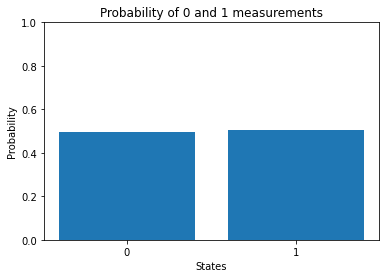

In [52]:
counts = execute(BCgate_List, shots=2000)
ls = list(counts.values())
probs = ls/np.sum(ls)
create_histogram(probs)

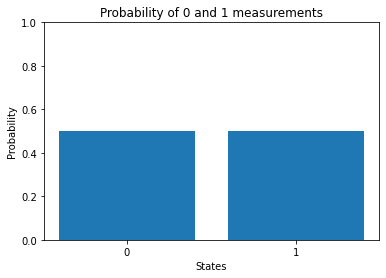

In [53]:
counts = execute(RCgate_List, shots=2000)
ls = list(counts.values())
probs = ls/np.sum(ls)
create_histogram(probs)

In [22]:
#lingering question: ask Phil if orientation of the vector matters, or just its position in the Bloch Sphere 
# - he said it shouldn't, so minusOpp should be fine to be assigned to Yn90 rotation

In [23]:
#bare = QuantumCircuit(3,1) 
#this is the sample circuit that we perform RC for in this code
#bare.h(0)
#bare.i(1)
#bare.cx(0,1) 
#bare.i(2) 
#end of the first cycle; each inputted circuit must be coded like this
#bare.barrier()

#bare.y(0)
#bare.i(1)
#bare.h(2)
#bare.cx(1,2)
#end of second cycle; the cx command can be placed anywhere within the barriers,
# but the single qubit gates must be assigned to qubits in ascending order
#bare.barrier()

#bare.i(0)
#bare.x(1)
#bare.i(2)
#the last cycle must contain no hard (cx) gates, only easy (single-qubit) gates.
#bare.draw()

#another restriction is the use of only H,X,Z,Y,I, and CNOT gates initially

In [24]:
#bare2 = QuantumCircuit(4)
#bare2.x(0)
#bare2.x(1)
#bare2.cx(0,1) 
#bare2.x(2) 
#bare2.z(3)
#end of the first cycle; each inputted circuit must be coded like this
#bare2.barrier()

#bare2.y(0)
#bare2.i(1)
#bare2.h(2)
#bare2.z(3)
#bare2.cx(1,3)

#end of second cycle; the cx command can be placed anywhere within the barriers,
# but the single qubit gates must be assigned to qubits in ascending order
#bare2.barrier()

#bare2.i(0)
#bare2.x(1)
#bare2.i(2)
#bare2.h(3)
#the last cycle must contain no hard (cx) gates, only easy (single-qubit) gates.
#bare2.draw()